In [1]:
import glob
import pandas as pd
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display
from IPython.display import clear_output
from google.colab import drive
from keras.initializers import RandomNormal
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/NoiceGAN/Test8'

Mounted at /content/gdrive


# Load and prepare dataset

In [2]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [3]:
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels  = tf.keras.utils.to_categorical(test_labels,  10)

In [5]:
amount_to_Cut = int(np.floor((np.ma.size(train_images,axis=0)/BATCH_SIZE))*BATCH_SIZE)

train_images = train_images[:amount_to_Cut,:,:]
train_labels = train_labels[:amount_to_Cut,:]


In [6]:
train_images = (train_images) / 256  # Normalize the images to [0, 1]
train_images = train_images.astype(np.float32)

test_images = (test_images) / 256
test_images = test_images.astype(np.float32)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.11111111, 0.11111111, 0.11111111, 0.        , 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111],
      dtype=float32)>

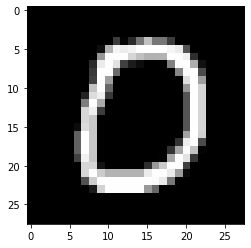

In [7]:
plt.plot()
plt.imshow(test_images[10,:, :], cmap='gray')
(tf.ones_like(train_labels[10])-train_labels[10])/9

In [8]:
# Batch and shuffle the data
dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#train_Output = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)

# Create Models

In [9]:
init = RandomNormal(mean=0.0, stddev=0.02)

### Generator

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(20+10,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

### Discriminator

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(10))

    return model

# Define Loss and Optimizers

In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy_categorical = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cross_entropy_binary = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [13]:
def discriminator_loss(y_pred,y_real):
    return cross_entropy_categorical(y_real,y_pred)

In [14]:
def generator_loss(y_pred,y_real,gen_out):


    indices = tf.math.argmax(y_real,axis=1)

    arr = []
    for i in range(BATCH_SIZE):
      arr.append(y_pred[i,indices[i]])

    final_cross_entropy = cross_entropy_binary(tf.zeros_like(indices),arr)

    # norm_calculated = tf.norm(gen_out,ord=2,axis=[1,2])
    # lp_loss = tf.reduce_mean(norm_calculated)

    # final_loss = final_cross_entropy+lambda_parameter*lp_loss
    
    #--------------------------All Neurons---------------------------------

    # # CROSS-ENTROPY-CATEGORICAL
    # # There must be a better way to do this, look into it more later!
    # mean_tensor_single = tf.math.reduce_mean(y_pred,axis=1)
    # mean_tensor_multi = tf.stack([mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single],axis=1)
    # final_cross_entropy = cross_entropy_categorical(mean_tensor_multi,y_pred)

    # #GENERATOR OUTPUT L2 LOSS
    # flattened_x = tf.reshape(gen_out,(BATCH_SIZE,28*28))
    # norm_calculated = tf.norm(flattened_x,ord=2,axis=1)
    # lp_loss = tf.reduce_mean(norm_calculated)

    # #SUM OF THE TWO WITH WEIGHT
    # final_loss = final_cross_entropy+0.3*lp_loss

    #--------------------------Single Neuron---------------------------------

    # indices = tf.math.argmax(y_real,axis=1)

    # arr = []
    # for i in range(BATCH_SIZE):
    #   arr.append(y_pred[i,indices[i]])

    # mean_tensor_single = tf.math.reduce_mean(y_pred,axis=1)

    # final_cross_entropy = cross_entropy_categorical(mean_tensor_single,arr)

    # #GENERATOR OUTPUT L2 LOSS
    # flattened_x = tf.reshape(gen_out,(BATCH_SIZE,28*28))
    # norm_calculated = tf.norm(flattened_x,ord=2,axis=1)
    # lp_loss = tf.reduce_mean(norm_calculated)

    # #SUM OF THE TWO WITH WEIGHT
    # final_loss = final_cross_entropy+0*lp_loss



    return final_cross_entropy






In [15]:
def disc_evaluate(x,y):

  predictions = np.argmax(discriminator(x).numpy(),axis=1)
  
  return 1-((np.count_nonzero(np.argmax(y,axis=1)-predictions))/BATCH_SIZE)

In [16]:
def gen_norm_mean(x):
  #flattened_x = np.reshape(x,(BATCH_SIZE,28*28))
  norm_calculated = tf.norm(x,ord=2,axis=[1,2])
  norm_mean = tf.math.reduce_mean(norm_calculated)
  return norm_mean.numpy()

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# Define training loop

In [18]:
EPOCHS = 500
noise_dim = 20
num_examples_to_generate = 9

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)

rand_y = [0,1,2,3,4,5,6,7,8]
rand_y = tf.keras.utils.to_categorical(rand_y, 10)
#print(rand_y)
#rand_y = np.append(np.ones((num_examples_to_generate,1)),np.zeros((num_examples_to_generate, 9)),axis=1)

seed = np.append(rand_y,tf.random.normal([num_examples_to_generate, noise_dim]),axis=1)


In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_only_gen(train_X,train_Y,lambda_norm):
    train_X = tf.cast(train_X, tf.float32)
    rand_y_in = tf.experimental.numpy.append(train_Y, tf.random.normal([BATCH_SIZE, noise_dim]), axis=1)


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      generated_noise = generator(rand_y_in, training=True)
      generated_noise = tf.squeeze(generated_noise)
      
      disc_output = discriminator(generated_noise+train_X, training=True)

      gen_loss = generator_loss(disc_output,train_Y,generated_noise)
      disc_loss = discriminator_loss(disc_output, train_Y)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    #gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss


In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step_together(train_X,train_Y,lambda_norm):
    train_X = tf.cast(train_X, tf.float32)
    rand_y_in = tf.experimental.numpy.append(train_Y, tf.random.normal([BATCH_SIZE, noise_dim]), axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      generated_noise = generator(rand_y_in, training=True)
      generated_noise = generated_noise * lambda_norm
      generated_noise = tf.squeeze(generated_noise)
      
      disc_output = discriminator(generated_noise+train_X, training=True)

      gen_loss = generator_loss(disc_output,train_Y,generated_noise)
      disc_loss = discriminator_loss(disc_output, train_Y)

    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_only_disc(train_X,train_Y,lambda_norm):
    train_X = tf.cast(train_X, tf.float32)
    rand_y_in = tf.experimental.numpy.append(train_Y, tf.random.normal([BATCH_SIZE, noise_dim]), axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      generated_noise = generator(rand_y_in, training=True)
      generated_noise = tf.squeeze(generated_noise)
      
      disc_output = discriminator(generated_noise+train_X, training=True)

      gen_loss = generator_loss(disc_output,train_Y,generated_noise)
      disc_loss = discriminator_loss(disc_output, train_Y)

    #gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss

In [22]:
def train(dataset, epochs,train_time,current_lambda):
  for epoch in range(epochs):
    print("epoch: "+ str(epoch))
    gen_loss_sum = 0
    disc_loss_sum = 0

    start = time.time()

    
    for x,y in dataset:      
      train_time = train_time+1


      #Evaluation Metrics:------------------------
      rand_in = tf.random.normal([BATCH_SIZE, noise_dim])
      x = tf.cast(x, tf.float32)

      generated_noise = generator(np.append(y,rand_in,axis=1), training=False)
      generated_noise = tf.squeeze(generated_noise)

      norm_evals.append(gen_norm_mean(generated_noise))

      disc_wo_noise_accuracy.append(disc_evaluate(x,y))
      disc_w_noise_accuracy.append(disc_evaluate(x+generated_noise,y))
      #--------------------------------------------
        

      gen_loss,disc_loss = train_step_together(x,y,tf.constant(current_lambda))


      gen_loss_sum = gen_loss_sum + gen_loss
      disc_loss_sum = disc_loss_sum + disc_loss
      gen_loss_evals.append(gen_loss.numpy())
      disc_loss_evals.append(disc_loss.numpy())
      lambda_evals.append(current_lambda)

      if (train_time%3)==0:

        clear_output()

        print("2nd order Norm: " + str(gen_norm_mean(generated_noise)))
        print("Discriminator w/o Noise Accuracy: "+str(disc_evaluate(x,y)))
        print("Discriminator w/  Noise Accuracy: "+str(disc_evaluate(x+generated_noise,y)))
        print("Generator Loss: "+ str(gen_loss.numpy()))
        print("Discriminator Loss: "+ str(disc_loss.numpy()))

        plot_metrics(norm_evals,disc_w_noise_accuracy,disc_wo_noise_accuracy,gen_loss_evals,disc_loss_evals,seed,generator,train_time,lambda_evals,current_lambda)
      
      if (train_time >= 1000 ):
        return



    # Save the model every 5 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  #generate_and_save_images(generator,seed)


In [23]:
def plot_metrics(norm_evals,disc_w_noise_accuracy,disc_wo_noise_accuracy,gen_loss_evals,disc_loss_evals,test_input,model,training_step,lambda_evals,lmbd):

  # Three subplots sharing both x/y axes
  f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=False,figsize=(12,8))

  ax1.plot(norm_evals,label="Norm")

  ax2.plot(disc_w_noise_accuracy,label="w Noise accuracy")
  ax2.plot(disc_wo_noise_accuracy,label="wo Noise accuracy")

  ax3.plot(gen_loss_evals,label="Gen Loss")
  ax4.plot(disc_loss_evals,label="Disc Loss")


  ax1.legend()
  ax2.legend()
  ax3.legend()
  ax4.legend()
  
  # Fine-tune figure; make subplots close to each other and hide x ticks for
  # all but bottom plot.
  f.subplots_adjust(hspace=0)
  plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

  plt.savefig(images_dir+'/'+str(lmbd)+'/Graph/'+str(training_step)+'.png')
  #---------------------------------------------------------------------------------------------

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(7, 10))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

    
  plt.savefig(images_dir+'/'+str(lmbd)+'/Gen_output/'+str(training_step)+'.png')

  

  plt.show()

# Experiment (Test9)

In [39]:
all_loss = []
for lmbd in np.float32(np.linspace(0.9,0.1,9)):

  print('----------'+str(lmbd)+'----------')

  #Restart graph session
  tf.keras.backend.clear_session()

  #Generate New Models
  generator = make_generator_model()
  discriminator = make_discriminator_model()

  #Set up optimizer and checkpoints(Never used, putting it here just in case)
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                  discriminator_optimizer=discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)
  
  #Reset train_time to zero
  train_time=0

  #Initialize metric save arrays
  gen_loss_evals = []
  disc_loss_evals = []
  loss_for_attacker = []
  

  #Start training with new lmbd number
  min_gen_loss = 100
  for x,y in dataset:      
      train_time = train_time+1
      
      gen_loss,disc_loss = train_step_together(x,y,tf.constant(lmbd))

      gen_loss_evals.append(gen_loss.numpy())
      disc_loss_evals.append(disc_loss.numpy())

      if(train_time > 100 and gen_loss_evals[-2]<min_gen_loss and gen_loss_evals[-2]<gen_loss_evals[-1]):
        min_gen_loss = gen_loss_evals[-1]
        print("-----Fitting for attacker: "+str(train_time)+"-----Loss:"+str(min_gen_loss))
        history = test_model_w_attacker()
        loss_for_attacker.append(history.history['val_loss'][-1])

  all_loss.append(np.mean(np.array(loss_for_attacker)))
  #Save arrays as csv file
  #df = pd.DataFrame(list(zip(norm_evals, disc_w_noise_accuracy,disc_wo_noise_accuracy,gen_loss_evals,disc_loss_evals)),
                #columns =['Generator Norm', 'Disc_acc (w/ noise)','Disc_acc (w/o noise)','Generator Loss','Discriminator Loss'])

  #df.to_csv(images_dir+'/'+str(lmbd)+'/out.csv',index=False)

----------0.9----------
-----Fitting for attacker: 101-----Loss:0.70019394
Epoch 1/2
219/219 [==============================] - 2s 6ms/step - loss: 0.2967 - accuracy: 0.9139 - val_loss: 0.0125 - val_accuracy: 0.9963
Epoch 2/2
219/219 [==============================] - 1s 6ms/step - loss: 0.0098 - accuracy: 0.9981 - val_loss: 0.0138 - val_accuracy: 0.9963
-----Fitting for attacker: 104-----Loss:0.74099696
Epoch 1/2
219/219 [==============================] - 2s 7ms/step - loss: 0.2815 - accuracy: 0.9149 - val_loss: 0.0096 - val_accuracy: 0.9980
Epoch 2/2
219/219 [==============================] - 1s 6ms/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 0.0055 - val_accuracy: 0.9983
-----Fitting for attacker: 106-----Loss:0.75035834
Epoch 1/2
219/219 [==============================] - 2s 6ms/step - loss: 0.2772 - accuracy: 0.9174 - val_loss: 0.0084 - val_accuracy: 0.9973
Epoch 2/2
219/219 [==============================] - 1s 6ms/step - loss: 0.0114 - accuracy: 0.9974 - val_loss: 0.0098 

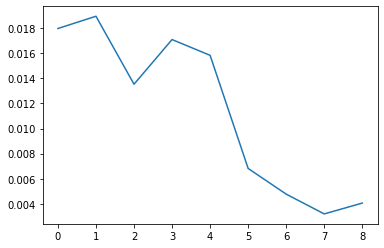

In [41]:
plt.figure()
plt.plot(all_loss)

In [30]:
def test_model_w_attacker():
  #Prepare y values and random values for input to generator
  rand_y_in = tf.experimental.numpy.append(test_labels, tf.random.normal([test_labels.shape[0], noise_dim]), axis=1)
  
  #Generate noises for rand_y_in
  generated_noise = generator(rand_y_in, training=False)
  generated_noise = generated_noise * 0.5
  generated_noise = tf.squeeze(generated_noise)

  #Add noises to x images
  noisy_images = generated_noise.numpy()+test_images

  #Create a new attacker model that has the same architecture as GAN discriminator, and try to fit to noisy x inputs
  attacker_model = make_discriminator_model()
  attacker_model.compile(optimizer=tf.keras.optimizers.Adam(),loss=cross_entropy_categorical,metrics=["accuracy"])
  return attacker_model.fit(noisy_images,test_labels,validation_split=0.3,epochs=2)

Epoch 1/2
219/219 [==============================] - 3s 10ms/step - loss: 0.2932 - accuracy: 0.9106 - val_loss: 0.0058 - val_accuracy: 0.9983
Epoch 2/2
219/219 [==============================] - 2s 8ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 0.9997


In [38]:
history.history['val_loss'][-1]

0.0026047516148537397

# Experiment (Test9)

In [ ]:
for lmbd in np.float32(np.linspace(0.3,0.1,3)):

  print('----------'+str(lmbd)+'----------')

  #Restart graph session
  tf.keras.backend.clear_session()

  #Generate New Models
  generator = make_generator_model()
  discriminator = make_discriminator_model()

  #Set up optimizer and checkpoints(Never used, putting it here just in case)
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                  discriminator_optimizer=discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)
  
  #Reset train_time to zero
  train_time=0

  #Initialize metric save arrays
  norm_evals = []
  disc_w_noise_accuracy = []
  disc_wo_noise_accuracy = []
  gen_loss_evals = []
  disc_loss_evals = []
  lambda_evals = []

  #Start training with new lmbd number
  train(dataset, EPOCHS,train_time,lmbd)

  #Save arrays as csv file
  df = pd.DataFrame(list(zip(norm_evals, disc_w_noise_accuracy,disc_wo_noise_accuracy,gen_loss_evals,disc_loss_evals)),
                columns =['Generator Norm', 'Disc_acc (w/ noise)','Disc_acc (w/o noise)','Generator Loss','Discriminator Loss'])

  df.to_csv(images_dir+'/'+str(lmbd)+'/out.csv',index=False)

# Train

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
train_time=0

In [ ]:
#Initialize arrays to save metrics (to plot)
norm_evals = []
disc_w_noise_accuracy = []
disc_wo_noise_accuracy = []
gen_loss_evals = []
disc_loss_evals = []
lambda_evals = []

2nd order Norm: 15.187191
Discriminator w/o Noise Accuracy: 0.7578125
Discriminator w/  Noise Accuracy: 0.015625
Generator Loss: 0.8081722
Discriminator Loss: 1.8529973


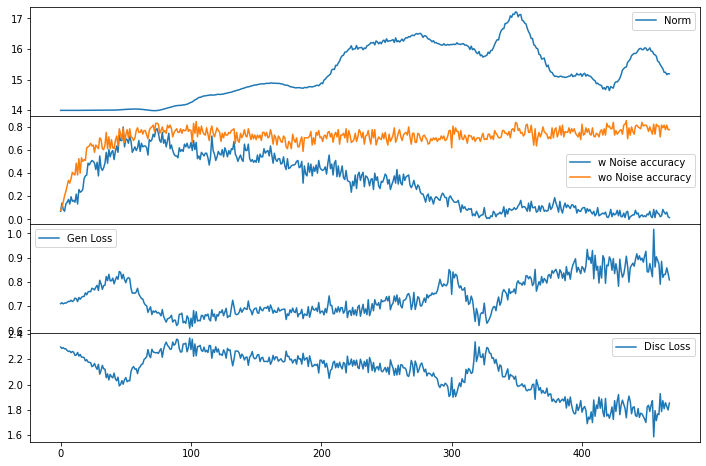

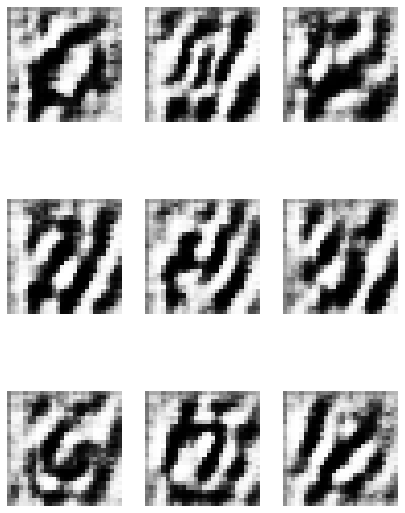

KeyboardInterrupt: ignored

In [ ]:
train(dataset, EPOCHS,train_time,0.5)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Test Trained Generator

In [ ]:
#train_X = tf.cast(train_X, tf.float32)
rand_y_in = tf.experimental.numpy.append(test_labels, tf.random.normal([test_labels.shape[0], noise_dim]), axis=1)

generated_noise = generator(rand_y_in, training=False)
generated_noise = generated_noise * 0.5
generated_noise = tf.squeeze(generated_noise)

In [ ]:

##test_images.shape

In [ ]:
noisy_images = generated_noise.numpy()+test_images
attacker_model = make_discriminator_model()
attacker_model.compile(optimizer=tf.keras.optimizers.Adam(),loss=cross_entropy_categorical,metrics=["accuracy"])
attacker_model.fit(noisy_images,test_labels,validation_split=0.3,epochs=10)

Epoch 1/10
219/219 [==============================] - 4s 11ms/step - loss: 0.1560 - accuracy: 0.9526 - val_loss: 0.0053 - val_accuracy: 0.9987
Epoch 2/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0057 - val_accuracy: 0.9990
Epoch 3/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0039 - val_accuracy: 0.9987
Epoch 4/10
219/219 [==============================] - 2s 7ms/step - loss: 2.9413e-04 - accuracy: 1.0000 - val_loss: 8.7832e-04 - val_accuracy: 0.9997
Epoch 5/10
219/219 [==============================] - 2s 7ms/step - loss: 8.3875e-05 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 0.9997
Epoch 6/10
219/219 [==============================] - 1s 6ms/step - loss: 5.9417e-05 - accuracy: 1.0000 - val_loss: 9.2252e-04 - val_accuracy: 0.9997
Epoch 7/10
219/219 [==============================] - 1s 5ms/step - loss: 4.5288e-05 - accuracy: 1.0000 - val_loss: 0.0010 - va

(-0.5, 27.5, 27.5, -0.5)

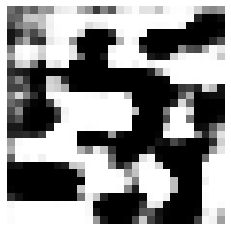

In [ ]:
generated_image = generator(seed, training=False)
generated_image[7, :, :, 0].shape#

plt.imshow(generated_image[7, :, :, 0], cmap='gray')
plt.axis('off')

<tf.Tensor: shape=(), dtype=float32, numpy=0.5007884>

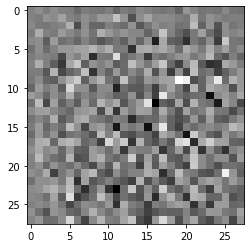

In [ ]:
generated_image = generator(seed, training=False)

plt.imshow(generated_image[7, :, :, 0], cmap='gray')
generated_image[7, 27, 27, 0]

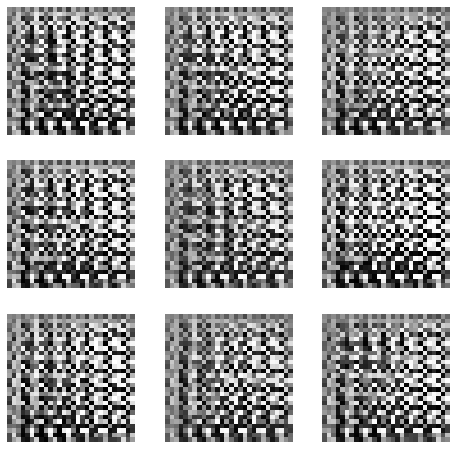

In [ ]:
generate_and_save_images(generator, seed)

In [ ]:
for x,y in dataset:
  mean_tensor_single = tf.math.reduce_mean(y,axis=1)
  print(mean_tensor_single)
  mean_tensor_multi = tf.stack([mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single],axis=1)
  print(mean_tensor_multi.shape)
  break

tf.Tensor(
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1], shape=(128,), dtype=float32)
(128, 10)
